In [1]:
import torch
import MiniFL as mfl
import numpy as np

In [2]:
STEPS = 400
SIZE = 32
NUM_CLIENTS = (2, 10, 50, 100, 200, 400)

In [3]:
EF21_METRICS = {}
RAND_METRICS = {}
PERMK_METRICS = {}
CORR_QUANT_METRICS = {}
DECORR_QUANT_METRICS = {}

In [4]:
def measure_all(seed, num_clients, steps=STEPS):
    def get_task(seed):
        return mfl.tasks.create_worst_case_tridiagonal_quadratics(
            num_clients=num_clients,
            size=SIZE,
            noise_lambda=0,
            seed=seed,
        )

    master, clients = mfl.algorithms.get_marina_master_and_clients(
        get_task(seed),
        # compressors=[mfl.compressors.EdenUnbiasedCompressor(SIZE, bits=1, world_size=num_clients,seed=1 + 7*seed + i) for i in range(num_clients)],
        compressors=[mfl.compressors.RandKUnbiasedCompressor(SIZE, p=1/num_clients, seed=1 + 7*seed + i) for i in range(num_clients)],
        gamma_multiplier=1,
        seed=1 + 13 * seed,
    )
    rand_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, steps)

    master, clients = mfl.algorithms.get_permk_marina_master_and_clients(
        get_task(seed+1),
        p=1/num_clients,
        gamma_multiplier=1,
        seed=7 + 5 * seed,
    )
    permk_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, int(steps * max(1, num_clients/70)))

    master, clients = mfl.algorithms.get_marina_master_and_clients(
        get_task(seed+2),
        compressors=[mfl.compressors.CorrelatedQuantizer(SIZE, rank=i, world_size=num_clients, num_levels=1, seed=seed) for i in range(num_clients)],
        gamma_multiplier=1,
        seed=1 + 13 * seed,
    )
    corr_quant_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, steps)

    master, clients = mfl.algorithms.get_marina_master_and_clients(
        get_task(seed+2),
        compressors=[mfl.compressors.DeCorrelatedQuantizer(SIZE, world_size=num_clients, num_levels=1, seed=seed+i) for i in range(num_clients)],
        gamma_multiplier=1,
        seed=9 + 17 * seed,
    )
    decorr_quant_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, steps)

    return rand_metrics, permk_metrics, corr_quant_metrics, decorr_quant_metrics

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot():
    fig, axes = plt.subplots(len(NUM_CLIENTS), 1, figsize=(16, 30))

    for i, num_clients in enumerate(NUM_CLIENTS):
        ax = axes[i]
        ax.set_title(f"{num_clients=}")

        try:
            ax.plot([metrics.total_bits_received/num_clients for metrics in RAND_METRICS[num_clients]], [metrics.grad_norm**2 for metrics in RAND_METRICS[num_clients]], color="red", linestyle="--", label="RandK")
            ax.plot([metrics.total_bits_received/num_clients for metrics in PERMK_METRICS[num_clients]], [metrics.grad_norm**2 for metrics in PERMK_METRICS[num_clients]], color="red", label="PermK")
            ax.plot([metrics.total_bits_received/num_clients for metrics in CORR_QUANT_METRICS[num_clients]], [metrics.grad_norm**2 for metrics in CORR_QUANT_METRICS[num_clients]], color="blue", label="Correlated Quantization")
            ax.plot([metrics.total_bits_received/num_clients for metrics in DECORR_QUANT_METRICS[num_clients]], [metrics.grad_norm**2 for metrics in DECORR_QUANT_METRICS[num_clients]], color="blue", linestyle="--", label="Uncorrelated Quantization")
        except KeyError:
            pass

        ax.set_yscale("log")
        # ax.set_xlim(0, 1.5*1e6)
        ax.set_ylim(top=0.1)
        ax.set_xlabel("bits/n")
        ax.set_ylabel(r"$\|\nabla f(x)\|_2^2$")
        ax.legend()

    return fig
    

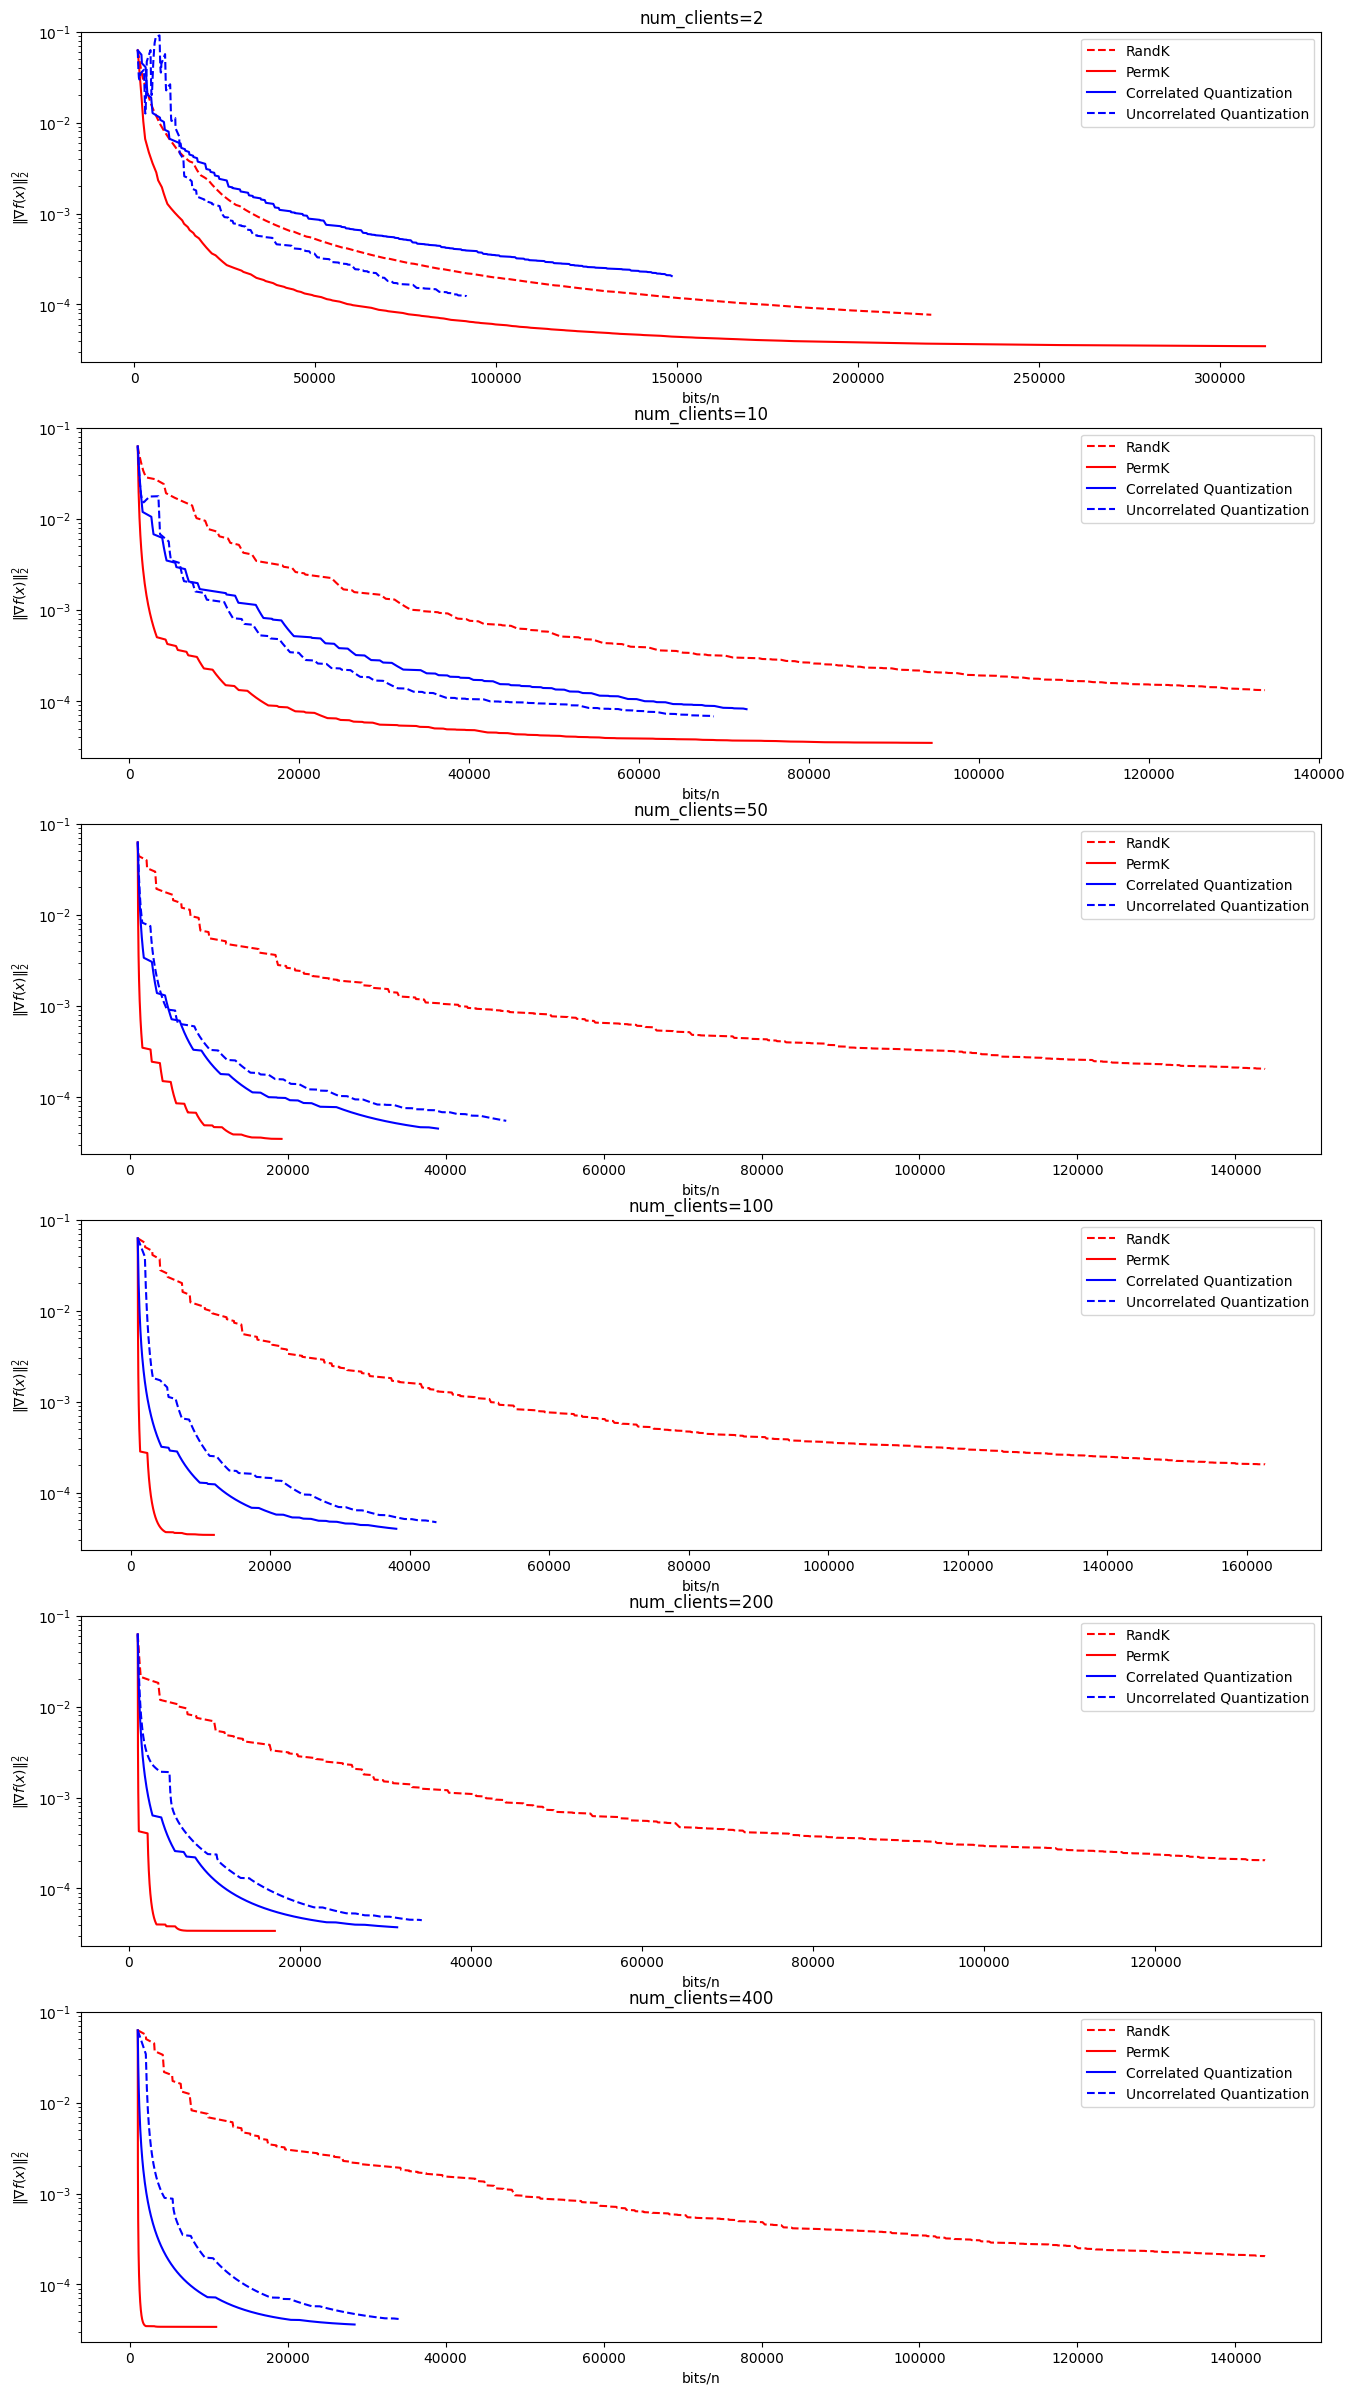

In [6]:
from IPython.display import clear_output

for i, num_clients in enumerate(NUM_CLIENTS):
    print(f"Measuring {num_clients=}")
    rand_metrics, permk_metrics, corr_quant_metrics, decorr_quant_metrics = measure_all(seed=101*i, num_clients=num_clients)
    RAND_METRICS[num_clients] = rand_metrics
    PERMK_METRICS[num_clients] = permk_metrics
    CORR_QUANT_METRICS[num_clients] = corr_quant_metrics
    DECORR_QUANT_METRICS[num_clients] = decorr_quant_metrics
    clear_output(wait=True)
    plot()
    plt.show()


In [7]:
# fig = plot()
# fig.savefig("Quadratics.pdf", bbox_inches='tight')